In [1]:
!pip install pandas tensorflow

Implementación en MLP de la solución, es normal que el código demore 

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import datetime

In [4]:
file_url = "input_data.csv"
dataframe = pd.read_csv(file_url, dtype= {
'loan_amnt': np.float32,
'index': int,
'term' : str, 
'installment' : np.float32,
'emp_title' : 'str', 
'purpose' : 'str', 
'title' : 'str', 
'dti' : np.float32,
'collections_12_mths_ex_med' : np.float32,
'application_type' : 'str', 
'tot_coll_amt' : np.float32,
'tot_cur_bal' : np.float32,
'open_acc_6m' : np.float32,
'open_act_il' : np.float32,
'open_il_12m' : np.float32,
'open_il_24m' : np.float32,
'mths_since_rcnt_il' : np.float32,
'total_bal_il' : np.float32,
'open_rv_12m' : np.float32,
'open_rv_24m' : np.float32,
'max_bal_bc' : np.float32,
'all_util' : np.float32,
'inq_fi' : np.float32,
'total_cu_tl' : np.float32,
'inq_last_12m' : np.float32,
'avg_cur_bal' : np.float32,
'chargeoff_within_12_mths' : np.float32,
'mo_sin_old_rev_tl_op' : np.float32,
'mo_sin_rcnt_rev_tl_op' : np.float32,
'mo_sin_rcnt_tl' : np.float32,
'num_accts_ever_120_pd' : np.float32,
'num_actv_bc_tl' : np.float32,
'num_actv_rev_tl' : np.float32,
'num_bc_sats' : np.float32,
'num_bc_tl' : np.float32,
'num_il_tl' : np.float32,
'num_op_rev_tl' : np.float32,
'num_rev_accts' : np.float32,
'num_rev_tl_bal_gt_0' : np.float32,
'num_sats' : np.float32,
'num_tl_120dpd_2m' : np.float32,
'num_tl_30dpd' : np.float32,
'num_tl_90g_dpd_24m' : np.float32,
'num_tl_op_past_12m' : np.float32,
'pct_tl_nvr_dlq' : np.float32,
'pub_rec_bankruptcies' : np.float32,
'tax_liens' : np.float32,
'tot_hi_cred_lim' : np.float32,
'total_il_high_credit_limit' : np.float32,
'disbursement_method' : 'str', 
'is_risky' : np.int32,
    })
dataframe.set_index("index", inplace=True)
dataframe.dropna(inplace=True)
dataframe.reset_index(drop=True,inplace=True)

In [5]:
to_int_cols = ['chargeoff_within_12_mths', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'pub_rec_bankruptcies']
dataframe[to_int_cols] = dataframe[to_int_cols].astype(np.int32)

In [6]:
dataframe.shape

(1172538, 50)

In [7]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1172538 entries, 0 to 1172537
Data columns (total 50 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   loan_amnt                   1172538 non-null  float32
 1   term                        1172538 non-null  object 
 2   installment                 1172538 non-null  float32
 3   emp_title                   1172538 non-null  object 
 4   purpose                     1172538 non-null  object 
 5   title                       1172538 non-null  object 
 6   dti                         1172538 non-null  float32
 7   collections_12_mths_ex_med  1172538 non-null  float32
 8   application_type            1172538 non-null  object 
 9   tot_coll_amt                1172538 non-null  float32
 10  tot_cur_bal                 1172538 non-null  float32
 11  open_acc_6m                 1172538 non-null  float32
 12  open_act_il                 1172538 non-null  float32
 1

In [8]:
val_dataframe = dataframe.sample(frac=0.6, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 469015 samples for training and 703523 for validation


In [9]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("is_risky")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

In [10]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'loan_amnt': <tf.Tensor: shape=(), dtype=float32, numpy=13300.0>, 'term': <tf.Tensor: shape=(), dtype=string, numpy=b' 36 months'>, 'installment': <tf.Tensor: shape=(), dtype=float32, numpy=517.62>, 'emp_title': <tf.Tensor: shape=(), dtype=string, numpy=b'Solution Specialist '>, 'purpose': <tf.Tensor: shape=(), dtype=string, numpy=b'debt_consolidation'>, 'title': <tf.Tensor: shape=(), dtype=string, numpy=b'Debt consolidation'>, 'dti': <tf.Tensor: shape=(), dtype=float32, numpy=22.74>, 'collections_12_mths_ex_med': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'application_type': <tf.Tensor: shape=(), dtype=string, numpy=b'Individual'>, 'tot_coll_amt': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'tot_cur_bal': <tf.Tensor: shape=(), dtype=float32, numpy=24134.0>, 'open_acc_6m': <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, 'open_act_il': <tf.Tensor: shape=(), dtype=float32, numpy=2.0>, 'open_il_12m': <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, 'open_il_24m': <tf.T

In [11]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

In [12]:
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.layers.experimental.preprocessing import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_string_categorical_feature(feature, name, dataset, num_clases = 20):
    # Create a StringLookup layer which will turn strings into integer indices
    index = StringLookup()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    index.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = index(feature)

    # Create a CategoryEncoding for our integer indices
    encoder = CategoryEncoding(output_mode="binary", max_tokens=num_clases)

    # Prepare a dataset of indices
    feature_ds = feature_ds.map(index)

    # Learn the space of possible indices
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices
    encoded_feature = encoder(encoded_feature)
    return encoded_feature


def encode_integer_categorical_feature(feature, name, dataset, num_clases = 20):
    # Create a CategoryEncoding for our integer indices
    encoder = CategoryEncoding(output_mode="binary", max_tokens=num_clases)

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the space of possible indices
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices
    encoded_feature = encoder(feature)
    return encoded_feature

In [13]:
#Categorical feature encoded as numeric
num_tl_120dpd_2m = keras.Input(shape=(1,), name="num_tl_120dpd_2m", dtype="int64")
num_tl_30dpd = keras.Input(shape=(1,), name="num_tl_30dpd", dtype="int64")
pub_rec_bankruptcies = keras.Input(shape=(1,), name="pub_rec_bankruptcies", dtype="int64")

# Categorical feature encoded as string
application_type = keras.Input(shape=(1,), name="application_type", dtype="string")
purpose = keras.Input(shape=(1,), name="purpose", dtype="string")
term = keras.Input(shape=(1,), name="term", dtype="string")

# Numerical features
loan_amnt = keras.Input(shape=(1,),name="loan_amnt")
avg_cur_bal = keras.Input(shape=(1,), name="avg_cur_bal")
dti = keras.Input(shape=(1,), name="dti")
installment = keras.Input(shape=(1,), name="installment")
num_tl_90g_dpd_24m = keras.Input(shape=(1,), name="num_tl_90g_dpd_24m")
num_tl_op_past_12m = keras.Input(shape=(1,), name="num_tl_op_past_12m")



#Categorical feature encoded as numeric
num_tl_120dpd_2m_encoded = encode_integer_categorical_feature(num_tl_120dpd_2m, "num_tl_120dpd_2m", train_ds,8)
num_tl_30dpd_encoded = encode_integer_categorical_feature(num_tl_30dpd, "num_tl_30dpd", train_ds,)
pub_rec_bankruptcies_encoded = encode_integer_categorical_feature(pub_rec_bankruptcies, "pub_rec_bankruptcies", train_ds, 10)

# Categorical feature encoded as string
application_type_encoded = encode_string_categorical_feature(application_type, "application_type", train_ds,2)
purpose_encoded = encode_string_categorical_feature(purpose, "purpose", train_ds, 14)
term_encoded = encode_string_categorical_feature(term, "term", train_ds,2)

# Numerical features
loan_amnt_encoded = encode_numerical_feature(loan_amnt, "loan_amnt", train_ds)
avg_cur_bal_encoded = encode_numerical_feature(avg_cur_bal, "avg_cur_bal", train_ds)
dti_encoded = encode_numerical_feature(dti, "dti", train_ds)
installment_encoded = encode_numerical_feature(installment, "installment", train_ds)
num_tl_90g_dpd_24m_encoded = encode_numerical_feature(num_tl_90g_dpd_24m, "num_tl_90g_dpd_24m", train_ds)
num_tl_op_past_12m_encoded = encode_numerical_feature(num_tl_op_past_12m, "num_tl_op_past_12m", train_ds)

In [74]:
all_inputs = [
     application_type,
     num_tl_120dpd_2m,
     num_tl_30dpd,
     num_tl_90g_dpd_24m,
     num_tl_op_past_12m,
     pub_rec_bankruptcies,
     term,
     loan_amnt,
     avg_cur_bal,
     dti,
     installment,
     purpose,
]

all_features = layers.concatenate(
    [
     application_type_encoded,
     num_tl_120dpd_2m_encoded,
     num_tl_30dpd_encoded,
     num_tl_90g_dpd_24m_encoded,
     num_tl_op_past_12m_encoded,
     pub_rec_bankruptcies_encoded,
     term_encoded,
     loan_amnt_encoded,
     avg_cur_bal_encoded,
     dti_encoded,
     installment_encoded,
     purpose_encoded,
    ]
)

x = layers.Dense(25, activation="relu")(all_features) # 12 features
x = layers.Dropout(0.1)(x)
x = layers.Dense(30, activation="relu")(x)
x = layers.Dense(10, activation="relu")(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)

In [75]:
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

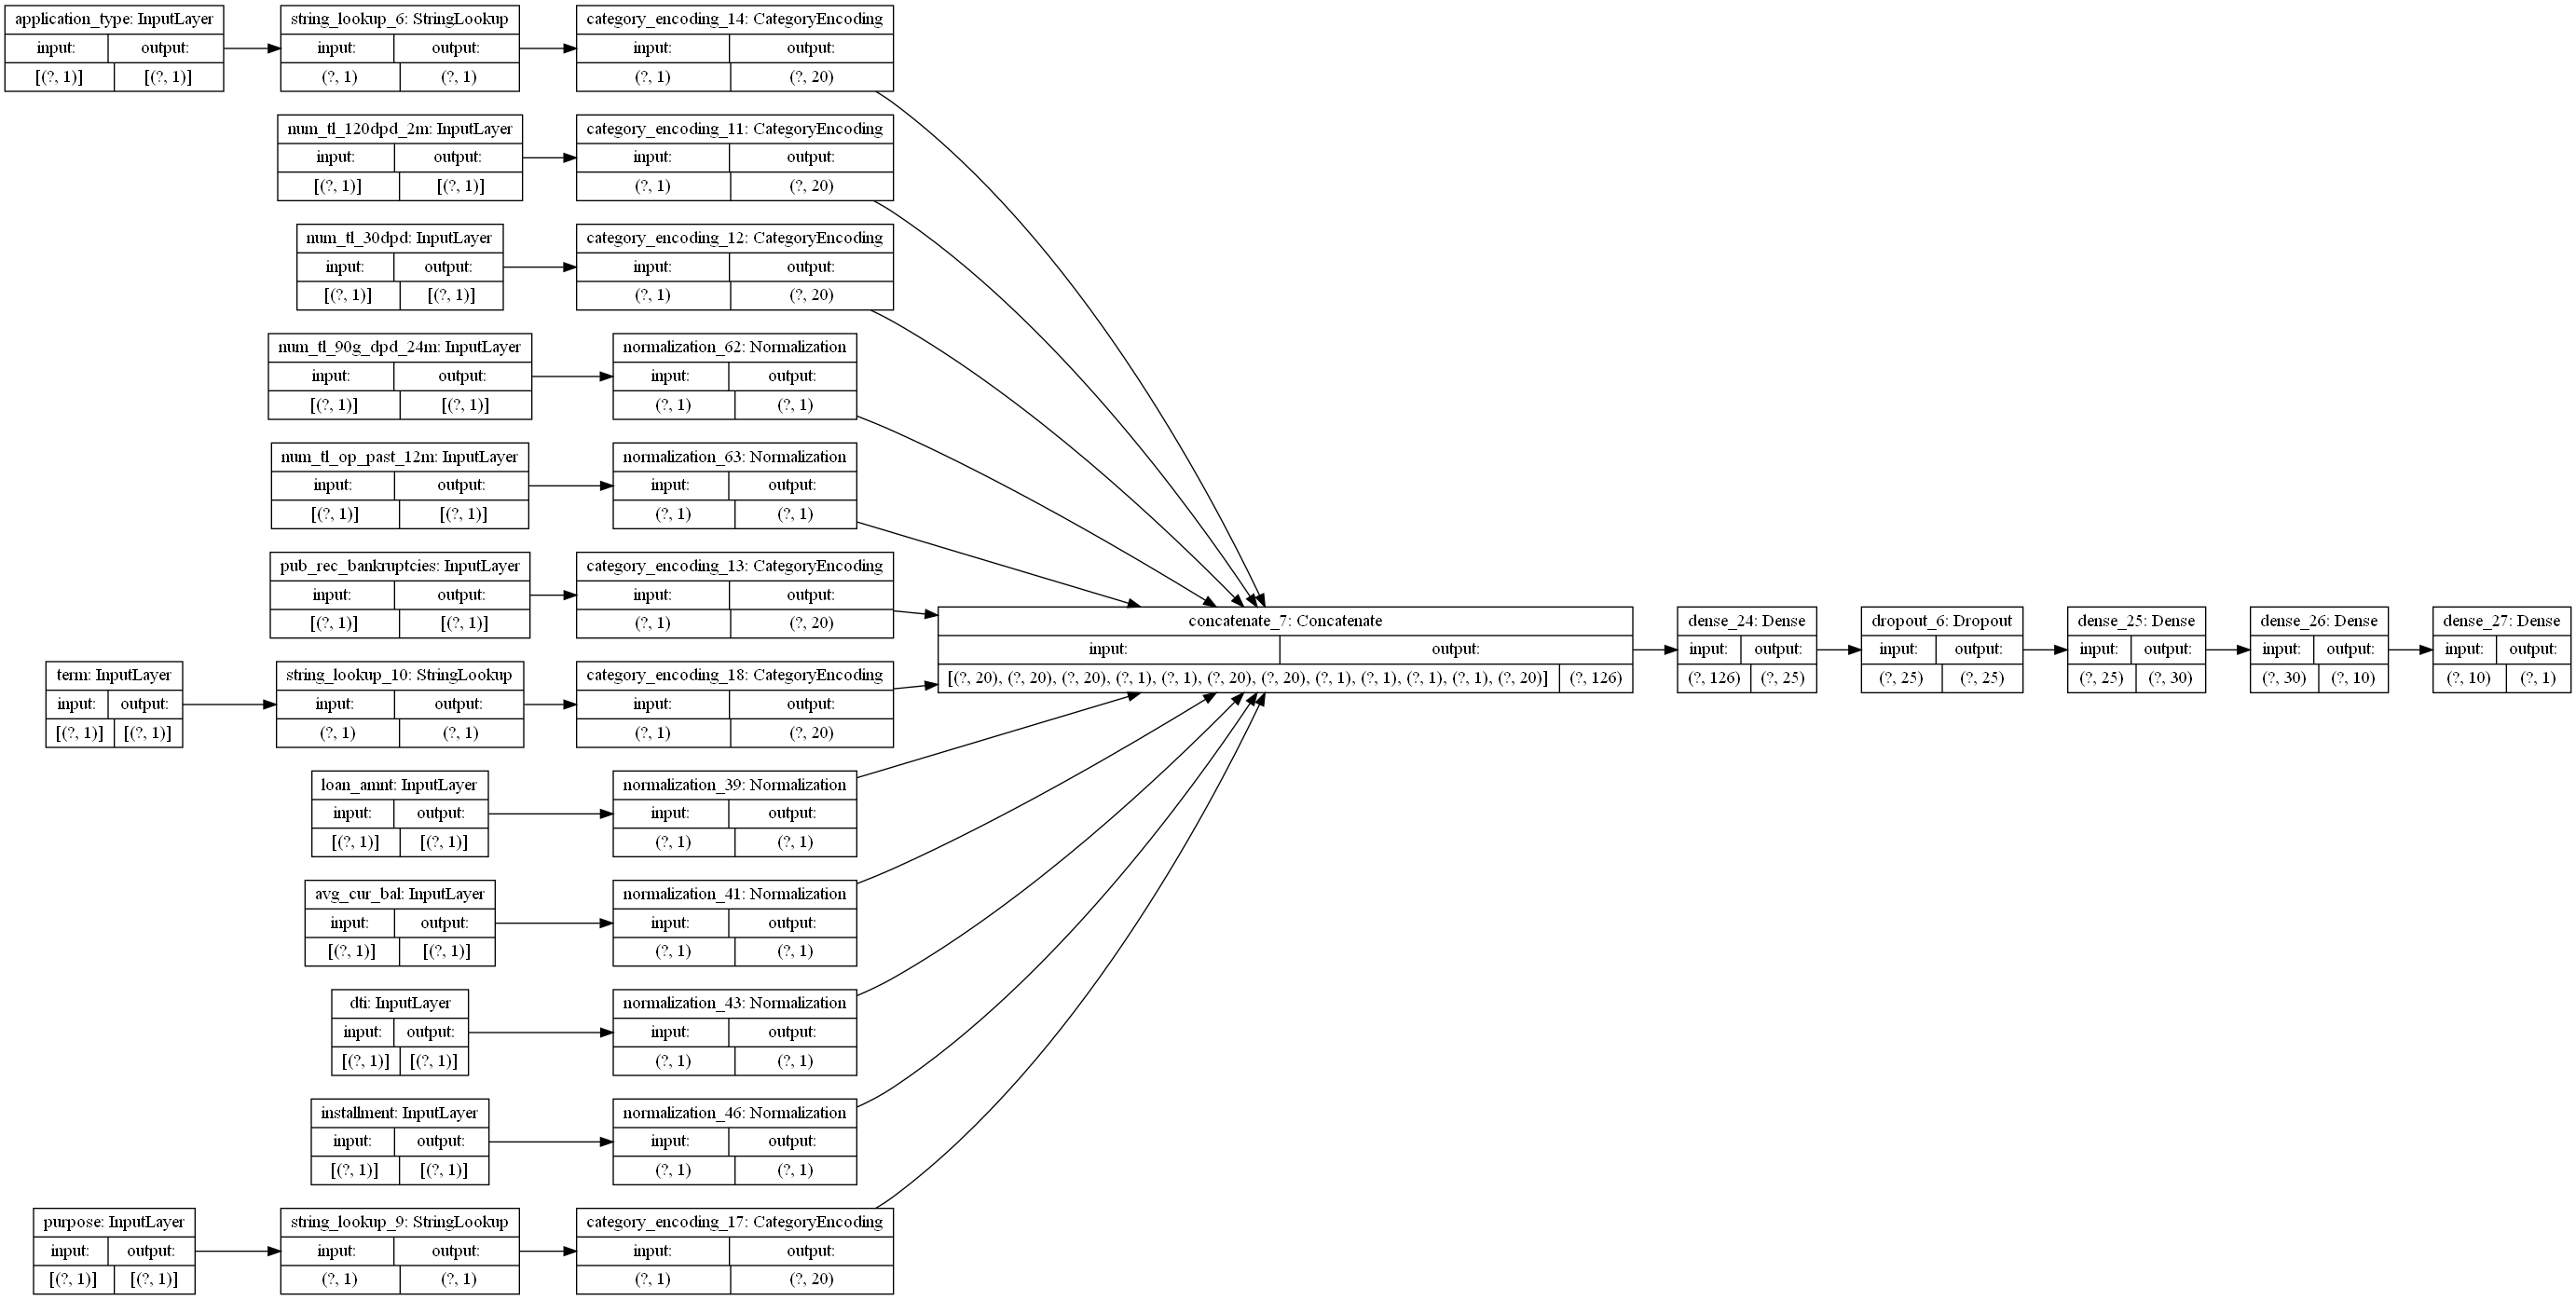

In [76]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model,to_file="model5.png", show_shapes=True, rankdir="LR")

Podemos notar que el input actual es de 126 y que las variables categóricas todas marcan 20 clases (a pesar de no tener 20 clases) esto se debe al parámetro `max_tokens` dado por tensorflow. Comparando la mejora o diferencias entre la versión con los encodings especificados (dando 52 entradas) vs esta definición, como se esperaba, la precisión y el error convergieron más cuando las clases eran específicas. Simplemente ahora sí se ejecutaba al cargar el modelo guardado (ya sea el guardado por checkpointer o guardado manualmente). No se pudo mandar a ejecutar el modelo corregido a tiempo, **este notebook está configurado para darle un valor de entradas correcto.**

![Comparativa](comparativa.png)

En base a esta comparativa, el modelo tendrá un mejor comportamiento con las clases especificadas y probablemente aumentando las épocas a 100.

In [77]:
model.summary()

Model: "functional_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
application_type (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
term (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
purpose (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
string_lookup_6 (StringLookup)  (None, 1)            0           application_type[0][0]           
______________________________________________________________________________________

In [78]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='ia5.model.best.tf', verbose=1, save_best_only=True)

logdir = "logs/scalars/ia5-" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

model.fit(train_ds, epochs=50,
          callbacks=[tensorboard_callback,checkpointer],
          validation_data=val_ds)

Epoch 1/50


c:\users\paula\onedrive - escuela superior politécnica del litoral\guillermo\ia\ia\lib\site-packages\tensorflow\python\keras\engine\functional.py:540: UserWarning: Input dict contained keys ['emp_title', 'title', 'collections_12_mths_ex_med', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'chargeoff_within_12_mths', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'pct_tl_nvr_dlq', 'tax_liens', 'tot_hi_cred_lim', 'total_il_high_credit_limit', 'disbursement_method'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


14657/14657 [==============================] - ETA: 0s - loss: 0.2786 - accuracy: 0.8804
Epoch 00001: val_loss improved from inf to 0.19610, saving model to ia5.model.best.tf
INFO:tensorflow:Assets written to: ia5.model.best.tf\assets
14657/14657 [==============================] - 286s 20ms/step - loss: 0.2786 - accuracy: 0.8804 - val_loss: 0.1961 - val_accuracy: 0.9237
Epoch 2/50
14657/14657 [==============================] - ETA: 0s - loss: 0.2098 - accuracy: 0.9196
Epoch 00002: val_loss did not improve from 0.19610
14657/14657 [==============================] - 283s 19ms/step - loss: 0.2098 - accuracy: 0.9196 - val_loss: 0.2041 - val_accuracy: 0.9206
Epoch 3/50
14657/14657 [==============================] - ETA: 0s - loss: 0.2036 - accuracy: 0.9226
Epoch 00003: val_loss did not improve from 0.19610
14657/14657 [==============================] - 289s 20ms/step - loss: 0.2036 - accuracy: 0.9226 - val_loss: 0.1994 - val_accuracy: 0.9204
Epoch 4/50
14657/14657 [=========================

Gráficas de precisión y error:

![Gráficas](graphs.png)

In [81]:
model = tf.keras.models.load_model("ia5.model.best.tf")
model.evaluate(val_ds)

21986/21986 [==============================] - 154s 7ms/step - loss: 0.1576 - accuracy: 0.9483


[0.15756158530712128, 0.948321521282196]

In [45]:
dataframe.groupby("application_type")["application_type"].count()

application_type
Individual    1074110
Joint App       98428
Name: application_type, dtype: int64

In [46]:
dataframe.groupby("purpose")["purpose"].count()

purpose
car                    13044
credit_card           263755
debt_consolidation    643226
educational                1
home_improvement       84892
house                   9011
major_purchase         28928
medical                16013
moving                  8732
other                  82523
renewable_energy         752
small_business         12370
vacation                9286
wedding                    5
Name: purpose, dtype: int64

In [47]:
dataframe.groupby("term")["term"].count()

term
 36 months    837284
 60 months    335254
Name: term, dtype: int64

In [48]:
dataframe.groupby("pub_rec_bankruptcies")["pub_rec_bankruptcies"].count()

pub_rec_bankruptcies
0    1029266
1     136626
2       5190
3       1033
4        284
5         93
6         32
7          9
8          4
9          1
Name: pub_rec_bankruptcies, dtype: int64

In [70]:
# Este era el error que le mencioné durante la exposición que se refiere al encoding categórico.

model = tf.keras.models.load_model("my_model6.tf")

#Individual	0	0	0	0.0	2.0	0	36 months	20000.0	30030.0	14.670000	637.580017	7.0	12.0	debt_consolidation
sample = {
    "application_type": "Individual",
    "num_tl_120dpd_2m": 0,
    "num_tl_30dpd": 0,
    "num_tl_90g_dpd_24m": 0,
    "num_tl_op_past_12m": 2,
    "pub_rec_bankruptcies": 0,
    "term": "36 months",
    "loan_amnt": 20000,
    "avg_cur_bal": 30030,
    "dti": 14.67,
    "installment": 637.58,
    "purpose": "debt_consolidation",
}

    sample["num_tl_120dpd_2m"] = int(sample["num_tl_120dpd_2m"])
    sample["num_tl_30dpd"] = int(sample["num_tl_30dpd"])
    sample["num_tl_90g_dpd_24m"] = float(sample["num_tl_90g_dpd_24m"])
    sample["num_tl_op_past_12m"] = float(sample["num_tl_op_past_12m"])
    sample["pub_rec_bankruptcies"] = float(sample["pub_rec_bankruptcies"])
    sample["loan_amnt"] = float(sample["loan_amnt"])
    sample["avg_cur_bal"] = float(sample["avg_cur_bal"])
    sample["dti"] = float(sample["dti"])
    sample["installment"] = float(sample["installment"])
#ds = tf.data.Dataset.from_tensor_slices((dict(sample_df), sample_df))
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)
print(predictions)

RuntimeError: If you construct a `CategoryEncoding` layer with `max_tokens=None`, you need to call `adapt()` on it before using it

A continuación se muestran las ejecuciones realizadas con tensorflow, se realizaron ejecuciones mediante plaidml sobre amd previamente sin embargo no se obtuvieron resultados satisfactorios.

Enlace de tensorboard [https://tensorboard.dev/experiment/RyckddAxToe3vlMq71N6AA/](https://tensorboard.dev/experiment/RyckddAxToe3vlMq71N6AA/)

Ejecuciones realizadas (positivas):

![Ejecucionesposi](ejecuciones-posi.png)

Ejecuciones realizadas, no tan sastifactorias:

![ejecucionesnoposi](ejecuciones-noposi.png)